#Density Sensitive projection

In [424]:
%matplotlib inline

import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn import random_projection
from itertools import groupby
from heapq import heappush, heappop
import random
from sklearn import svm
from pylab import rcParams
from sklearn.utils.extmath import safe_sparse_dot

# Use seaborn styles for nice-looking plots
import seaborn; seaborn.set()

# Define some functions
def plotHyperplane(normal, intercept=0, label='', plt=plt):
    """ Plot a hyperplane given a normal and an intercept
    """
    a = -normal[0] / normal[1]
    xx = np.linspace(-10, 10)
    yy = a * xx - (intercept) / normal[1]    
    plt.plot(xx, yy, label=label)    
    return 0

def hashWithMedianPlane(p, X):
    """ hash using median plane
    """
    w = p[0] - p[1]    
    t = np.dot((p[0]+p[1])/2,w)
    
    res = np.inner(w, X)    
    
    return ['1' if elem >= t else '0' for elem in res]


def medianPlane(p):
    """Generate median plane given two points
    """    
    median = (p[0]+p[1]) / 2
    diff = p[0] - p[1]
    
    # hyperplane    
    intercept = -np.dot(median,diff)    

    return (diff, intercept)

def generateBitString( x ):
    return "".join(['1' if i > 0 else '0' for i in x])

class HashBucketScreening:
    """HashBucketScreening class"""    
    
    def __init__(self, features, rnd=42,maxplanes=40,strategy='median',maxCutoff=0.5):
        self.maxplanes = maxplanes
        rng = np.random.RandomState(rnd) 
        self.randomProjection = random_projection.gaussian_random_matrix(1, features, random_state=rng)        
        self.strategy = strategy
        self.maxCutoff = maxCutoff
        
    def _generateHyperplaneUsingSVM(self, X, Y):
        """ Here we estimate the seperating hyperplane using svm
        """
        plane = svm.SVC(kernel='linear', C=2)
        plane.fit(X,Y)
                
        return (plane, plane.coef_[0], plane.intercept_[0])
                
    def screen(self, X, Y):

        # Now generate a random plane through the origin - start of the algorithm
        # medians stores the hyperplane normals as well as intercepts                                   
        self.medians = [(self.randomProjection[0], 0)]   
                
        # Project #1
        projected = safe_sparse_dot(X, self.randomProjection.T)
        self.buckets = np.apply_along_axis( generateBitString, axis=1, arr=projected )

        plane = 1        
        
        self.select = []

        # This is the algorithm
        while True:          
            
            heap = []
            
            for key in np.unique(self.buckets):
                # estimate pos ratio        
                qualifying = Y[self.buckets == key]
                length = qualifying.shape[0]   
                pos = qualifying[qualifying == 1].shape[0]
                #print('Buckets', key, pos)        
                ratio = min(pos / length, (length - pos) / length)
                #print(key,ratio,length)
                if 0 < ratio < self.maxCutoff:
                    # Take buckets which need splitting - weight them by the number of points
                    heap.append(( length * ratio, key, pos, length))    

            if (len(heap) == 0) or (plane > self.maxplanes) :
                print('No more elements')
                break;                

            heap = sorted(heap, key=lambda x: x[0])         
            
            #print(heap)
            
            # select the bucket that needs splitting
            # get the smalles element 
            #largest = heap[0]#.pop()
            largest = heap.pop()

            # 3 strategies
            # Take random points 1) or 2) take the median of all pos/neg points each, simulates k-means

            # now from this "largest bucket" sample 1 pos and 1 neg point
            #qualifyingPos = random.choice(X[(buckets == largest[1]) & (Y == 1)])
            #qualifyingNeg = random.choice(X[(buckets == largest[1]) & (Y != 1)])

            # Strategy 2 take median of qualifying points
            if(self.strategy == 'median'):
                qualifyingPos = np.median(X[(self.buckets == largest[1]) & (Y == 1)],axis=0)
                qualifyingNeg = np.median(X[(self.buckets == largest[1]) & (Y != 1)],axis=0)
                median = (qualifyingPos, qualifyingNeg)
                
                # Store the median points
                self.medians.append(medianPlane(median))                

                # add the new bitstring to the hash
                self.buckets = np.core.defchararray.add(self.buckets, hashWithMedianPlane(median, X))

            
            if(self.strategy == 'SVM'):
                # Strategy 3 use SVM to find seperating hyperplane per bucket
                (svm, point, intercept) = self._generateHyperplaneUsingSVM(
                    X[self.buckets == largest[1]], Y[self.buckets == largest[1]])
                
                if(np.array_equal(point, self.medians[-1][0]) & (intercept == self.medians[-1][1])):
                    print('We have the same hyperplane .. going in circles, breaking')
                    break
                
                self.medians.append((point,intercept))
                
                newbit = ['1' if elem > 0 else '0' for elem in svm.decision_function(X)]                                

                self.select.append(X[self.buckets == largest[1]])
                
                self.buckets = np.core.defchararray.add(self.buckets, newbit)                                

                
            plane = plane + 1            
            
        print('Done after %d planes' % (plane))
        
    def getBucketSamples(self,X,Y,samples=2):
        """ Samples from all buckets #samples points
        """
        # Also just sample n point from all buckets
        sampledPoints = []
        data = np.column_stack((self.buckets, Y, X))   
        for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
            #sampledPoints.append(random.choice(list(rows)))
            l = list(rows)
            sampledPoints.extend(random.sample(l,min(samples,len(l))))

        sampledPoints = np.asarray(sampledPoints)     
        return sampledPoints
    
    def getHammingSamples(self,X,Y):
        """ Get all points that belong to hamming buckets that are support buckets
        """        
        data = np.column_stack((self.buckets, Y))  
        keySize = len(list(groupby(data[np.argsort(data[:,0])], lambda x: x[0])))

        X_hamming = np.empty([keySize, len(self.buckets[0])])
        Y_hamming = [0] * keySize
        counter = 0

        for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
            row = list(rows)        
            pos = len(list(filter(lambda x: x[1] == '1.0', row)))
            neg = len(list(filter(lambda x: x[1] != '1.0', row)))
                        
            X_hamming[counter:] = np.array(list(map(int, key))) 
            Y_hamming[counter] = 1 if pos > neg else 0
            counter = counter + 1   
    
        # Create Hamming Points and run SVM
        clf = svm.SVC(kernel='linear', C=2)
        clf.fit(X_hamming, Y_hamming)

        #print('Support Vectors:\n', clf.support_vectors_)
        print('All hamming points %d - reduced to %d' % (keySize, len(clf.support_vectors_)))
        
        self.selected = np.apply_along_axis( generateBitString, axis=1, arr=clf.support_vectors_)

        reduced_x = X[np.in1d(self.buckets, self.selected)]
        reduced_y = Y[np.in1d(self.buckets, self.selected)]        
        
        return (reduced_x, reduced_y)
    
    def getHammingSupportSamples(self, X, Y, samples):                
        data = np.column_stack((screen.buckets, Y, X))   
        sampledSupportBucket = []
        # Sample points from the support buckets only
        for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
            if key in self.selected:
                l = list(rows)
                sampledSupportBucket.extend(random.sample(l,min(samples,len(l))))

        sampledSupportBucket = np.asarray(sampledSupportBucket)   
                
        return (sampledSupportBucket[:,2:], sampledSupportBucket[:,1])
    
    def getPointsPerBucket(self, X, Y):
        dist = []
        for key in np.unique(self.buckets):
            qualifying = Y[self.buckets == key]
            pos = qualifying[qualifying == 1].shape[0]
            dist.append((key, qualifying.shape[0], pos, qualifying.shape[0] - pos))
        
        return dist


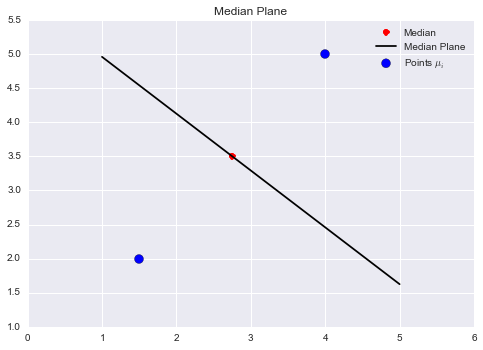

In [402]:
# Show the base of the algorithm
p = np.array( [ (1.5,2), (4,5) ] )

plt.scatter(p[:, 0], p[:, 1], s=80,
                 zorder=10, label='Points $\mu_i$')

# median of the centers
median = (p[0]+p[1]) / 2
diff = p[0] - p[1]
plt.plot(median[0],median[1], 'ro', label='Median')

# hyperplane
a = -diff[0] / diff[1]
intercept = -np.dot(median,diff)

xx = np.linspace(1, 5)
yy = a * xx - (intercept) / diff[1]

plt.plot(xx, yy, 'k-', label='Median Plane')
plt.title('Median Plane')
plt.legend()
plt.show()

Define Median Plane as $(x - \frac{\mu_i+\mu_j}{2})^T (\mu_i - \mu_j) = 0$

In [403]:
# Now generate some random points
rng = np.random.RandomState(42)
n_samples_1 = 200
n_samples_2 = 200
X = np.r_[2 * rng.randn(n_samples_1, 2) - [2,2],
          2 * rng.randn(n_samples_2, 2) + [2, 2]]
Y = np.array([0] * (n_samples_1) + [1] * (n_samples_2))

In [404]:
# Screen
screen = HashBucketScreening(X.shape[1], strategy='median')

%time screen.screen(X,Y)

No more elements
Done after 32 planes
Wall time: 59 ms


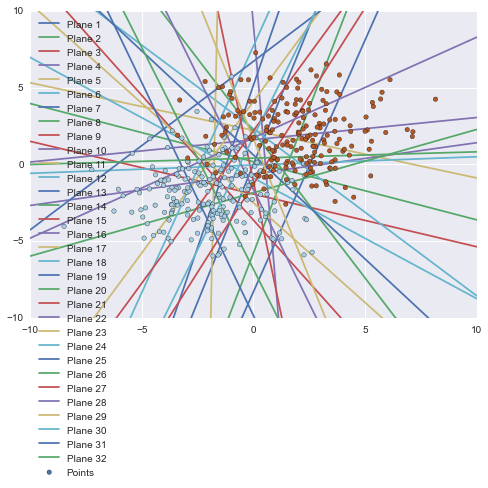

We need 32 bits to seperate all points


In [405]:
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, label='Points')
   
plane = 0
for (point, intercept) in screen.medians:
    plotHyperplane(point, intercept, 'Plane ' + str(plane + 1))
    plane = plane + 1
    
plt.legend(loc='upper left')
plt.ylim([-10,10])
plt.xlim([-10,10])
plt.show()

print('We need %d bits to seperate all points' % (plane))

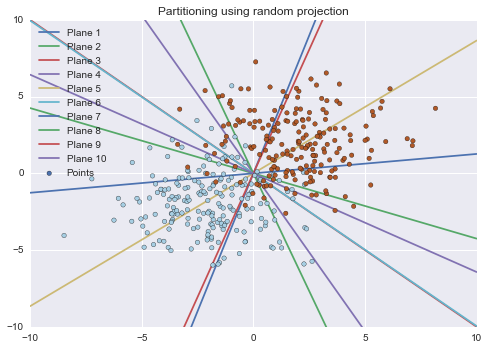

In [406]:
# Display using #planes random projections
rng = np.random.RandomState(42) 
randomProjection = random_projection.gaussian_random_matrix(10, X.shape[1], random_state=rng)  
# Plot
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, label='Points')
   
plane = 0
for (point) in randomProjection:
    plotHyperplane(point, 0, 'Plane ' + str(plane + 1))
    plane = plane + 1
        
plt.legend(loc='upper left')
plt.title('Partitioning using random projection')
plt.ylim([-10,10])
plt.xlim([-10,10])
plt.show()

In [407]:
# What if we use the random projection idea to generate the buckets
buckets = np.apply_along_axis( generateBitString, axis=1, arr=np.dot(X, randomProjection.T ))
heap = []

X_selected = []
Y_selected = []

for key in np.unique(buckets):
    # estimate pos ratio        
    qualifying = Y[buckets == key]
    length = qualifying.shape[0]   
    pos = qualifying[qualifying == 1].shape[0]
    #print('Buckets', key, pos)        
    ratio = min(pos / length, (length - pos) / length)
    #print(key,ratio,length)
    if 0 < ratio < 0.5:
        # Take buckets which need splitting - weight them by the number of points
        X_selected.extend(X[buckets == key])
        Y_selected.extend(Y[buckets == key])
        heap.append(( ratio, key, pos, length))  
        
X_selected = np.array(X_selected)        
        
# Now check if we still hit the same accuray
entire = svm.SVC(kernel='linear')
entire.fit(X,Y)        
        
# Now generate an svm with the points in the buckets
projectionSVM = svm.SVC(kernel='linear')
projectionSVM.fit(X_selected, Y_selected)
print('Random SVM Bucket %f with %d points' % (projectionSVM.score(X,Y),X_selected.shape[0] ))
print('Entire Dataset    %f'% (entire.score(X,Y)))

Random SVM Bucket 0.915000 with 341 points
Entire Dataset    0.915000


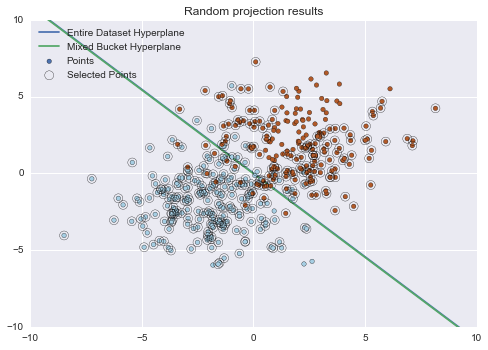

In [408]:
# plot the random svm 
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, label='Points')
plt.title('Random projection results')

plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=plt,label='Entire Dataset Hyperplane')
plotHyperplane(projectionSVM.coef_[0],projectionSVM.intercept_[0],plt=plt,label='Mixed Bucket Hyperplane')

plt.scatter(X_selected[:,0], X_selected[:,1],  s=80,
                facecolors='none', zorder=10, label='Selected Points')

plt.xlim([-10,10])
plt.ylim([-10,10])    
plt.legend(loc='upper left')
plt.show()

Generate Hamming points and label based on majority

In [409]:
keySize = np.unique(screen.buckets).shape[0]

X_hamming = np.empty([keySize, len(screen.buckets[0])])
Y_hamming = [0] * keySize
counter = 0

for key in np.unique(screen.buckets):
    qualifying = Y[screen.buckets == key]      
    pos = qualifying[qualifying == 1].shape[0]
    neg = qualifying[qualifying != 1].shape[0]
    X_hamming[counter:] = np.array(list(map(int, key))) 
    Y_hamming[counter] = 1 if pos > neg else 0
    counter = counter + 1   
    
# Create Hamming Points and run SVM
clf = svm.SVC(kernel='linear')
clf.fit(X_hamming, Y_hamming)

#print('Support Vectors:\n', clf.support_vectors_)
print('All hamming points %d - reduced to %d' % (keySize, len(clf.support_vectors_)))

All hamming points 159 - reduced to 64


##Testing on generated data

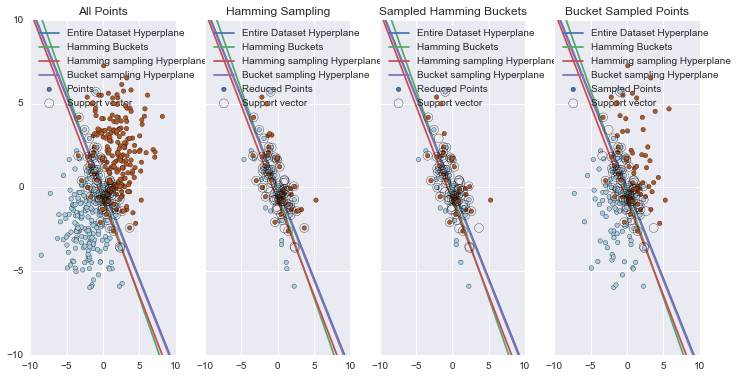

We have 76 support vectors in hamming space (down from 159)
Stats
All points 400 - hamming buckets 83  (20.75 %) - hamming sampled 64 (16.00 %) - bucket sampled 159 (39.75 %)


In [410]:
selected = np.apply_along_axis( generateBitString, axis=1, arr=clf.support_vectors_)

reduced_x = X[np.in1d(screen.buckets, selected)]
reduced_y = Y[np.in1d(screen.buckets, selected)]


sample_Number_of_points_hamming = 1

# Also just sample n point from all buckets
sampledPoints = []
data = np.column_stack((screen.buckets, X, Y))   
for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
    #sampledPoints.append(random.choice(list(rows)))
    l = list(rows)
    sampledPoints.extend(random.sample(l,min(1,len(l))))

sampledPoints = np.asarray(sampledPoints)     

sampledSupportBucket = []
# Sample points from the support buckets only
for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
    if key in selected:
        l = list(rows)
        sampledSupportBucket.extend(random.sample(l,min(sample_Number_of_points_hamming,len(l))))

sampledSupportBucket = np.asarray(sampledSupportBucket)     

rcParams['figure.figsize'] = (12.0, 6.0)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, sharex=True)

# Now check if we still hit the same accuray
entire = svm.SVC(kernel='linear')
entire.fit(X,Y)
reduced = svm.SVC(kernel='linear')
reduced.fit(reduced_x, reduced_y)

sSampled = svm.SVC(kernel='linear')
sSampled.fit(sampledSupportBucket[:, [1,2]].astype(float), sampledSupportBucket[:,3].astype(int))

bSampled = svm.SVC(kernel='linear')
bSampled.fit(sampledPoints[:, [1,2]].astype(float), sampledPoints[:,3].astype(int))

ax1.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, label='Points')
ax1.set_title('All Points')

ax2.scatter(reduced_x[:, 0], reduced_x[:, 1], c=reduced_y, zorder=10, cmap=plt.cm.Paired, label='Reduced Points')
ax2.set_title('Hamming Sampling')

ax3.scatter(sampledSupportBucket[:, 1], sampledSupportBucket[:, 2], c=sampledSupportBucket[:,3].astype(int), zorder=10, cmap=plt.cm.Paired, label='Reduced Points')
ax3.set_title('Sampled Hamming Buckets')

ax4.scatter(sampledPoints[:, 1], sampledPoints[:, 2], c=sampledPoints[:,3].astype(int),
            zorder=10, cmap=plt.cm.Paired, label='Sampled Points')
ax4.set_title('Bucket Sampled Points')


for plot in [ax1, ax2, ax3, ax4]: 
    plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=plot,label='Entire Dataset Hyperplane')
    plotHyperplane(reduced.coef_[0],reduced.intercept_[0], plt=plot, label='Hamming Buckets')
    plotHyperplane(sSampled.coef_[0],sSampled.intercept_[0], plt=plot, label='Hamming sampling Hyperplane')
    plotHyperplane(bSampled.coef_[0],bSampled.intercept_[0], plt=plot, label='Bucket sampling Hyperplane')
    plot.scatter(entire.support_vectors_[:, 0], entire.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10, label='Support vector')
    
    plot.legend(loc='upper left')
    
plt.xlim([-10,10])
plt.ylim([-10,10])    
plt.show()


print('We have %d support vectors in hamming space (down from %d)' % (len(entire.support_vectors_), keySize))

print('Stats\nAll points %d - hamming buckets %d  (%.2f %%) - hamming sampled %d (%.2f %%) - bucket sampled %d (%.2f %%)' % 
      (len(X), 
       len(reduced_x), 
       (len(reduced_x)/len(X)) * 100, 
       len(sampledSupportBucket),
       (len(sampledSupportBucket)/len(X)) * 100,
       len(sampledPoints), 
       (len(sampledPoints)/len(X)) * 100))


In [411]:
# Now check if we still hit the same accuray

print ('Classification accuracy on the entire dataset with all     points  %f ' % (entire.score(X,   Y)))
print ('Classification accuracy on the entire dataset with hamming points  %f ' % (reduced.score(X,  Y)))
print ('Classification accuracy on the entire dataset with hamming sampled %f ' % (sSampled.score(X, Y)))
print ('Classification accuracy on the entire dataset with buckets sampling %f ' % (bSampled.score(X, Y)))

Classification accuracy on the entire dataset with all     points  0.915000 
Classification accuracy on the entire dataset with hamming points  0.912500 
Classification accuracy on the entire dataset with hamming sampled 0.917500 
Classification accuracy on the entire dataset with buckets sampling 0.910000 


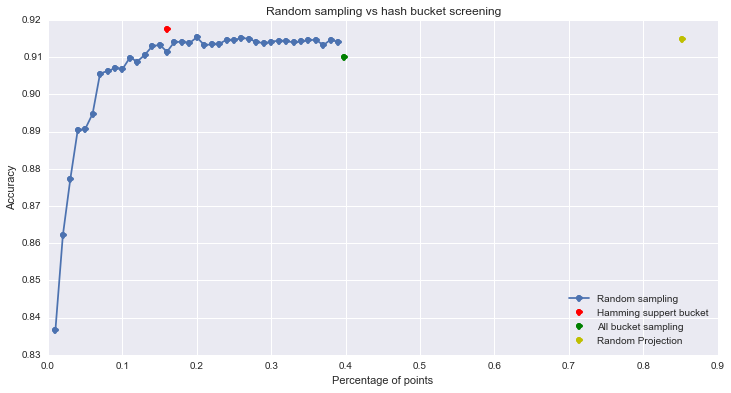

In [412]:
# Test against random sampling
randomSamplingResult = []
for sample in np.arange(0.01, 0.4, 0.01):
    # generate random subset multiple times
    x = []
    for tries in np.arange(0, 100):        
        selected = np.random.choice(np.arange(0, X.shape[0]), math.floor(X.shape[0] * sample), replace=False)
        sampled_X = X[selected]
        sampled_Y = Y[selected]
        # Now check if we still hit the same accuray
        randomSampling = svm.SVC(kernel='linear')
        try:
            randomSampling.fit(sampled_X,sampled_Y)
            x.append(randomSampling.score(X,   Y))
        except ValueError:
            pass
        
        #randomSamplingResult.append([sample,sampled_X.shape[0], randomSampling.score(X,   Y)])
    #print(sample,sampled_X.shape[0], randomSampling.score(X,   Y))
    #print('sample',sample,x,np.median(x))
    randomSamplingResult.append([sample,sampled_X.shape[0], np.mean(x)])

randomSamplingResult = np.array(randomSamplingResult)    
    
plt.title('Random sampling vs hash bucket screening')
plt.plot(randomSamplingResult[:,0], randomSamplingResult[:,2], '-o', label='Random sampling')
plt.plot(len(sampledSupportBucket)/len(X), sSampled.score(X, Y), 'ro',label='Hamming suppert bucket')
plt.plot((len(sampledPoints)/len(X)), bSampled.score(X, Y), 'go', label='All bucket sampling')

# random Projection results
plt.plot((len(X_selected)/len(X)), projectionSVM.score(X,Y), 'yo', label='Random Projection')


plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Percentage of points')
plt.show()

No more elements
Done after 30 planes
Wall time: 79.1 ms


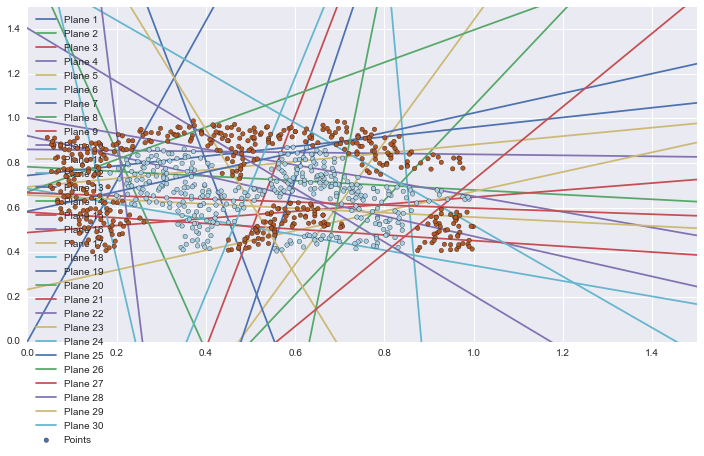

We need 31 bits to seperate all points


In [413]:
import scipy.io
data2 = scipy.io.loadmat('ex6data2.mat')    
    
# Screen
screen = HashBucketScreening(X.shape[1], strategy='median')

%time screen.screen(data2['X'], data2['y'].ravel())

plt.scatter(data2['X'][:,0], data2['X'][:,1], c=(data2['y'].flatten()), zorder=10, cmap=plt.cm.Paired, label='Points')
   
plane = 1
for (point, intercept) in screen.medians:
    plotHyperplane(point, intercept, 'Plane ' + str(plane))
    
    plane = plane + 1
    
plt.legend(loc='upper left')
plt.xlim([0, 1.5])
plt.ylim([0, 1.5])
plt.show()

print('We need %d bits to seperate all points' % (plane ))

In [418]:
# Try a larger dataset
import urllib
from sklearn.datasets import load_svmlight_file

#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/liver-disorders_scale'
#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms'
#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/skin_nonskin'
#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/svmguide1'

#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/splice_scale'
#testing  = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/splice.t'

#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/svmguide3'
#testing = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/svmguide3.t'

#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/madelon'
#testing = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/madelon.t'

#(X_train, Y_train) = load_svmlight_file(urllib.request.urlopen(training))
#(X_test, Y_test) = (X_train, Y_train)
#(X_test, Y_test) = load_svmlight_file(urllib.request.urlopen(testing))

(X_train, Y_train) = load_svmlight_file('./data/higg_lo_svm.csv')
(X_test, Y_test) = load_svmlight_file('./data/higg_lo_svm_test.csv')


#load_svmlight_file()
print('Testing on ' + training)

print(X_train.shape)
print(X_test.shape)

Testing on http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms
(9999, 21)
(999, 21)


In [427]:
import math
screen = HashBucketScreening(X_train.shape[1],strategy='median',maxCutoff=0.49)

%time screen.screen(X_train.toarray(), Y_train)

sPoints = screen.getBucketSamples(X_train.toarray(), Y_train,samples = 1)
                    
(r_x, r_y) = screen.getHammingSamples(X_train.toarray(), Y_train)

(s_x, s_y) = screen.getHammingSupportSamples(X_train.toarray(), Y_train, 1)

        
reducedPoints = svm.SVC(kernel='linear')
reducedPoints.fit(r_x, r_y)    

supportBucketSampled = svm.SVC(kernel='linear')
supportBucketSampled.fit(s_x, s_y.astype(float))    
    
bs = svm.SVC(kernel='linear')
bs.fit(sPoints[:, 2:].astype(float), sPoints[:,1].astype(float))    

d = svm.SVC(kernel='linear')
%time d.fit(X_train,Y_train)

print ('Classification accuracy on the entire dataset with all     points  %f ' % (d.score(X_test.toarray(),   Y_test)))
print ('Classification accuracy on the entire dataset with hamming points  %f ' % (reducedPoints.score(X_test.toarray(),   Y_test)))
print ('Classification accuracy on the entire dataset with sampled hamming %f ' % (supportBucketSampled.score(X_test.toarray(),  Y_test)))
print ('Classification accuracy on the entire dataset with buckets points  %f ' % (bs.score(X_test.toarray(),  Y_test)))

print('Stats\nAll points %d - hamming points %d  (%.2f %%) - sampled hamming %d (%.2f %%) - bucket sampled %d (%.2f %%)' % 
      (X_train.shape[0], 
       len(r_x),(len(r_x)/X_train.shape[0]) * 100,
       len(s_x),(len(s_x)/X_train.shape[0]) * 100,       
       len(sPoints),(len(sPoints)/X_train.shape[0]) * 100))


No more elements
Done after 33 planes
Wall time: 30.7 s
All hamming points 9889 - reduced to 9300
Wall time: 9.6 s
Classification accuracy on the entire dataset with all     points  0.557558 
Classification accuracy on the entire dataset with hamming points  0.573574 
Classification accuracy on the entire dataset with sampled hamming 0.565566 
Classification accuracy on the entire dataset with buckets points  0.547548 
Stats
All points 9999 - hamming points 9405  (94.06 %) - sampled hamming 9300 (93.01 %) - bucket sampled 9889 (98.90 %)
